In [1]:
#Import the libraries we’ll need
import os
import shutil 
import pandas as pd
import keras
import numpy as np
from os import listdir
import tensorflow as tf
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,ZeroPadding2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical   
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers.normalization import layer_normalization
from keras.layers import Activation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from keras.utils.np_utils import normalize

In [2]:
#The function for processing dataset into 3 tumor kinds and non_tumor kind
def split_data_into_4_class_dirs(dir):
  os.chdir(dir)
  train_csv = pd.read_csv("label.csv")
  directory = os.fsencode('image')

  for file in os.listdir(directory):
      filename = os.fsdecode(file)
      index = train_csv.index[train_csv['file_name'] == filename]
      if train_csv.loc[index.values[0],'label']=="no_tumor":
          shutil.copy('image/'+filename, '/content/drive/MyDrive/AMLS/dataset/no')
      elif train_csv.loc[index.values[0],'label']=="glioma_tumor":
          shutil.copy('image/'+filename, '/content/drive/MyDrive/AMLS/dataset/glioma_tumor')
      elif train_csv.loc[index.values[0],'label']=="meningioma_tumor":
        shutil.copy('image/'+filename, '/content/drive/MyDrive/AMLS/dataset/meningioma_tumor')
      elif train_csv.loc[index.values[0],'label']=="pituitary_tumor":
        shutil.copy('image/'+filename, '/content/drive/MyDrive/AMLS/dataset/pituitary_tumor')

  print(train_csv.groupby('label').count(),'\n')
  print("The number of MRI Images labelled glioma_tumor':",len(os.listdir('glioma_tumor')))
  print("The number of MRI Images labelled 'meningioma_tumor':",len(os.listdir('meningioma_tumor')))
  print("The number of MRI Images labelled 'no':",len(os.listdir('no')))
  print("The number of MRI Images labelled 'pituitary_tumor':",len(os.listdir('pituitary_tumor')))

In [5]:
#Invoke the previous function

# mount google drive to load the dataset uploaded on it 
from google.colab import drive
drive.mount('/content/drive')

#split_data_into_4_class_dirs("/content/drive/MyDrive/AMLS/dataset/") #If not the fisrt time run it, comment this line

Mounted at /content/drive


In [6]:
#The function for loading training data
def load_train_data(dir):
    X = []
    y = []
    os.chdir(dir)
    dirs = ['glioma_tumor', 'meningioma_tumor', 'no', 'pituitary_tumor']
    for directory in dirs:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = cv2.resize(image, dsize=(240,240))
            X.append(image)
            if directory == 'glioma_tumor':
                y.append([1])
            elif directory == 'meningioma_tumor':
                y.append([2])
            elif directory == 'no':
                y.append([0])
            elif directory == 'pituitary_tumor':
                y.append([3])
            else: 
              print("something went wrong !! ")
    X = np.array(X)
    X = normalize(X, axis=1)
    y = np.array(y)
    return X, y

In [10]:
#Invoke the previous function
data_dir ="/content/drive/MyDrive/AMLS/dataset/"
X, y = load_train_data(data_dir)

In [11]:
#Divide the dataset
y_enc = to_categorical(y, num_classes = 4)
X_train , X_test, y_train, y_test = train_test_split(X , y_enc , test_size = 0.1, random_state = 42)
X_train , X_val, y_train, y_val = train_test_split(X_train , y_train , test_size = 0.1, random_state = 42)

In [12]:
#The function for building the CNN model for task B
def build_model():
  tf.keras.backend.clear_session()
  model= Sequential()
  model.add(Conv2D(64, kernel_size =(5,5),padding='same', input_shape=(240,240,3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size =(3,3), padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(128, kernel_size =(3,3),padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, kernel_size =(3,3), padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(256, kernel_size =(3,3),padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.4))


  model.add(Flatten())
  model.add(Dense(units = 4, activation = 'softmax'))
  
  return model

In [13]:
#The function for ploting learning curves
def plot_learning_curves(history):  
  train_loss = history['loss']
  val_loss = history['val_loss']
  train_acc = history['accuracy']
  val_acc = history['val_accuracy']

  plt.figure()
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

In [14]:
#The function for getting accuracy metrics
def get_accuracy_metrics(X_test, y_test):
  print("Test Acc: ",model.evaluate(X_test,y_test, verbose=0)[1])
  pred = np.argmax(model.predict(X_test),axis = 1)
  print("Confusion Matrix : \n ",confusion_matrix(pred, np.argmax(y_test,axis=1)))
  print("\nprecision score:  ",precision_score(pred, np.argmax(y_test,axis=1),average='micro'))
  print("\nrecall score: ",recall_score(pred, np.argmax(y_test,axis=1),average='micro'))
  print("\nF1 Score: ",f1_score(np.round(pred), np.argmax(y_test,axis=1),average='micro'))

In [15]:
#Train the CNN model for task B
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
76/76 [==============================] - 30s 233ms/step - loss: 14.3421 - accuracy: 0.6366 - val_loss: 51.9631 - val_accuracy: 0.2704
Epoch 2/50
76/76 [==============================] - 14s 181ms/step - loss: 7.2326 - accuracy: 0.7864 - val_loss: 98.6450 - val_accuracy: 0.2704
Epoch 3/50
76/76 [==============================] - 14s 181ms/step - loss: 4.7443 - accuracy: 0.8535 - val_loss: 96.4262 - val_accuracy: 0.2704
Epoch 4/50
76/76 [==============================] - 14s 181ms/step - loss: 4.0022 - accuracy: 0.8700 - val_loss: 113.7500 - val_accuracy: 0.2704
Epoch 5/50
76/76 [==============================] - 14s 181ms/step - loss: 2.6980 - accuracy: 0.9000 - val_loss: 139.1998 - val_accuracy: 0.2704
Epoch 6/50
76/76 [==============================] - 14s 181ms/step - loss: 2.2809 - accuracy: 0.9239 - val_loss: 83.5799 - val_accuracy: 0.3000
Epoch 7/50
76/76 [==============================] - 14s 181ms/step - loss: 1.6361 - accuracy: 0.9440 - val_loss: 17.2254 - val_accura

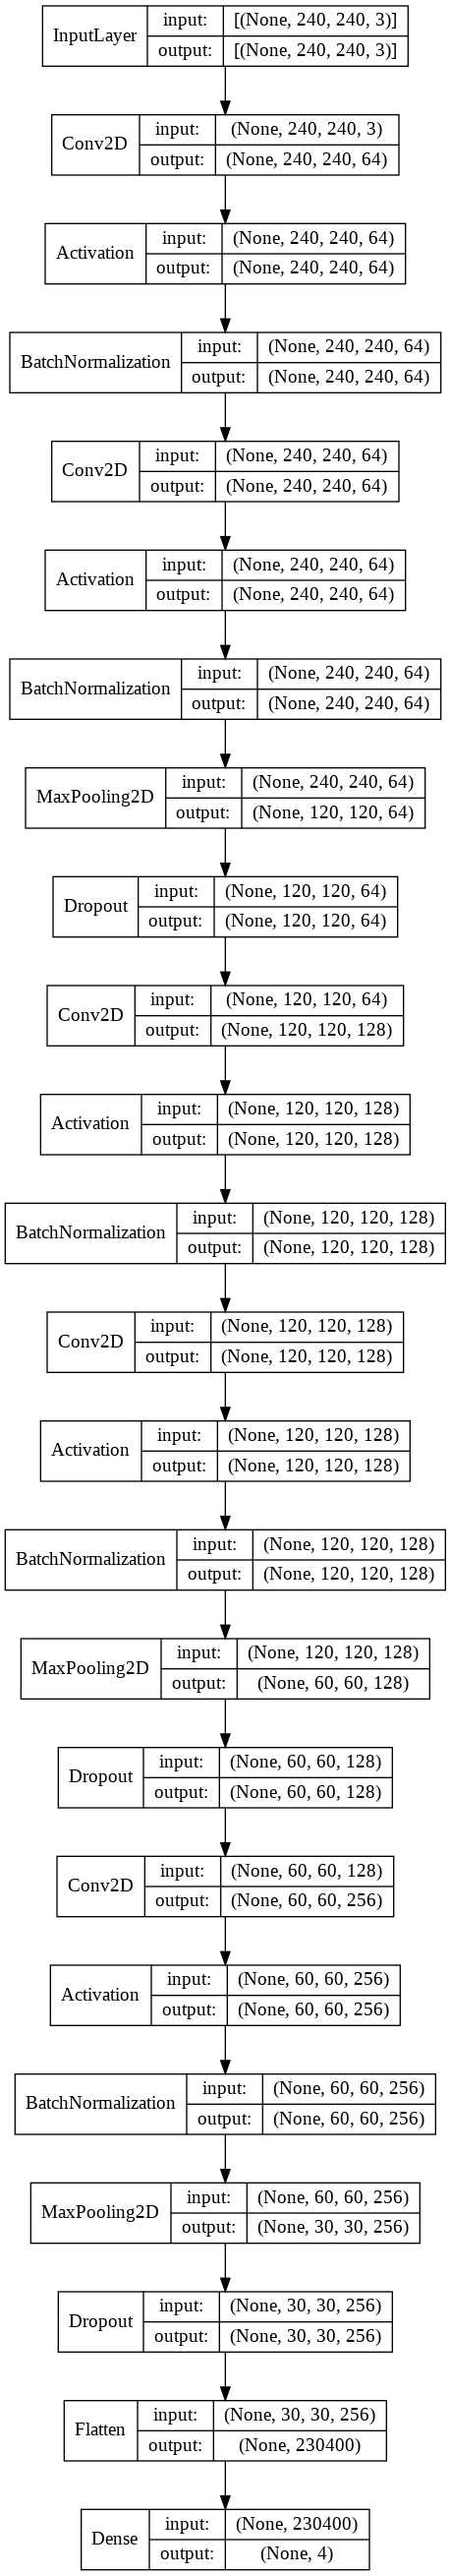

In [16]:
#Plot the CNN  
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=False)

     |████████████████████████████████| 795 kB 4.8 MB/s 


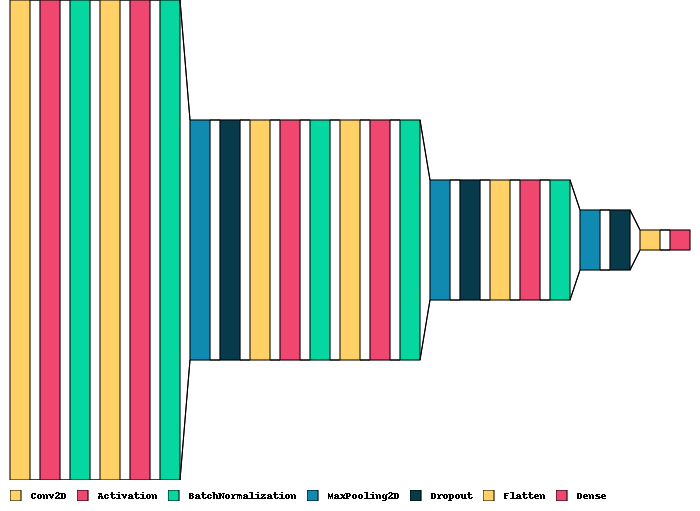

In [17]:
#Plot the CNN
!pip install visualkeras

import visualkeras
from PIL import ImageFont
#model = build_model()
visualkeras.layered_view(model, legend=True,draw_volume=False, scale_xy=2,scale_z=0.000001)

In [18]:
get_accuracy_metrics(X_test, y_test)

Test Acc:  0.8700000047683716
Confusion Matrix : 
  [[40  2  1  0]
 [ 3 83  7  0]
 [ 7 10 64  2]
 [ 1  1  5 74]]

precision score:   0.87

recall score:  0.87

F1 Score:  0.87


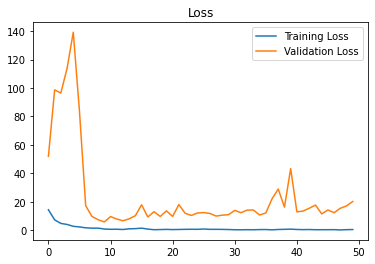

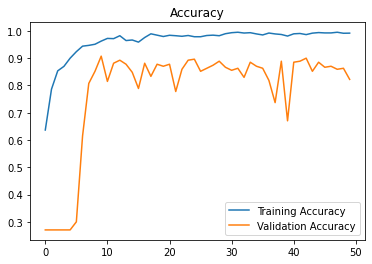

In [19]:
plot_learning_curves(history.history)

In [20]:
#The function for loading test data in order to provide scores
def load_test_data(dir):
  y_test = []
  X_test = [] 
  os.chdir(dir)

  y_test_csv = pd.read_csv('label.csv')
  image_name=y_test_csv['file_name'].to_list()
  label_name=y_test_csv['label'].to_list()
  for i in range(len(label_name)):  
    if label_name[i] == 'no_tumor':
        y_test.append(0)
    elif label_name[i] == "meningioma_tumor":
        y_test.append(2)
    elif label_name[i] == "pituitary_tumor":
        y_test.append(3)
    elif label_name[i] == "glioma_tumor":
      y_test.append(1)
    else:
        print("something went wrong !! ")

  y_test=np.array(y_test)
  y_test = to_categorical(y_test, num_classes = 4)
  
  directory = "image"
  for i in range(len(image_name)):
      image = (directory+'/'+image_name[i])
      image = cv2.imread(image)
      image = cv2.resize(image,(240,240))
      X_test.append(image)
  X_test = np.array(X_test)
  X_test=normalize(X_test, axis=1)
  return X_test,y_test

In [21]:
dir = "/content/drive/MyDrive/AMLS/test/"
X_test_data,y_test_data = load_test_data(dir)

In [22]:
get_accuracy_metrics(X_test_data, y_test_data)

Test Acc:  0.8949999809265137
Confusion Matrix : 
  [[30  3  0  0]
 [ 3 37  5  1]
 [ 3  3 61  0]
 [ 1  0  2 51]]

precision score:   0.895

recall score:  0.895

F1 Score:  0.895
